**Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Installing required Libraries**

In [2]:
!pip install torch transformers pandas numpy matplotlib


**Converting Data to Data Frames**

In [3]:
import pandas as pd

# Load dataset
url = 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv'
data = pd.read_csv(url)
data.head()


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [4]:
data['date'] = pd.to_datetime(data['date'])  # Convert to datetime if needed
data.set_index('date', inplace=True)         # Set the date as index


**Normalizing the Data, 0-1**

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


**Converting Data to Sequences**

In [6]:
import numpy as np

def create_sequences(data, seq_length=48):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 48  # Adjust based on dataset and needs
X, y = create_sequences(scaled_data, seq_length)


**Splitting into Train and Val**

In [7]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


**Tranformer Architecture**

In [8]:
import torch
import torch.nn as nn
import math

import torch
import torch.nn as nn
import math

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, seq_length, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        # Embedding Layer
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model, dropout, seq_length)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Additional Feed-Forward Layers
        self.fc1 = nn.Linear(d_model, d_model // 2)
        self.fc2 = nn.Linear(d_model // 2, output_dim)

        # Activation and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)

        # Apply Positional Encoding
        x = self.positional_encoding(x)

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # Take the output of the last timestep
        x = x[:, -1, :]

        # Additional Feed-Forward Layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Define Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix for positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine and cosine functions to alternate dimensions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer so it’s part of the model but not learnable
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)

# Define model parameters
input_dim = X_train.shape[2]
d_model = 128
nhead = 8
num_layers = 4
output_dim = y_train.shape[1]
seq_length = X_train.shape[1]  # Set this to the length of your input sequence

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, output_dim, seq_length)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


**Loss Function Def**

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


**Dataset Loader**

In [10]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


**Training Transformer Model**

In [11]:
epochs = 10  # Adjust based on performance

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")


Epoch 1, Train Loss: 0.010399692036834156, Val Loss: 0.0037178400109058518
Epoch 2, Train Loss: 0.0031765858178165523, Val Loss: 0.0031548790160273927
Epoch 3, Train Loss: 0.002402995457021666, Val Loss: 0.002215329444112252
Epoch 4, Train Loss: 0.002185362467000936, Val Loss: 0.002027266146321439
Epoch 5, Train Loss: 0.0020969367540539883, Val Loss: 0.0019377310909977003
Epoch 6, Train Loss: 0.0020134958548504497, Val Loss: 0.0017357218865806626
Epoch 7, Train Loss: 0.00199583815004851, Val Loss: 0.001990238191314798
Epoch 8, Train Loss: 0.0019511998102677657, Val Loss: 0.0019481532062938407
Epoch 9, Train Loss: 0.001932084034452464, Val Loss: 0.0018468363147278086
Epoch 10, Train Loss: 0.001921170614745376, Val Loss: 0.001708509677240343


**Eveluating Model**

In [12]:
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        predictions.append(output)
        actuals.append(y_batch)

predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# If scaled, inverse the scaling
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)


**Visualization**

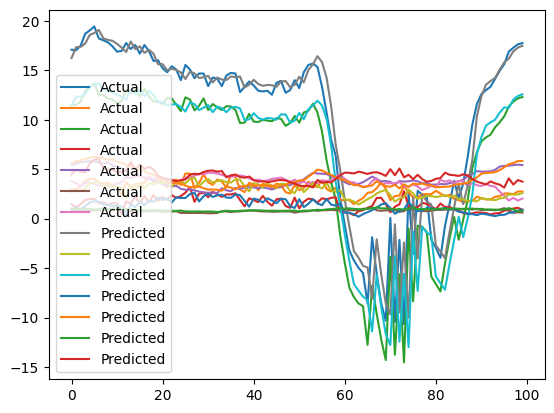

In [13]:
import matplotlib.pyplot as plt

plt.plot(actuals[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.show()
